In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

# Initializing parameters
Bi = 1
n = [100, 100, 100]
kappa = [1, 1, 1]
length = [1, 1, 1]

omega = np.logspace(-2, 4)
deltax = np.zeros(len(n))
D = np.zeros(len(n))
lamb = np.zeros(len(n), dtype=complex)

# Defining indices for pore terminations
l1 = n[0] + 1
l2 = l1 + n[1] + 2
l3 = l2 + n[2] + 2

for i in range(len(n)):
    deltax[i] = length[i] / (n[i] + 1)
    D[i] = kappa[i] / np.tanh(kappa[i])

# Initializing solutions
Z_num = np.array([])
Z_case1 = np.array([])
Z_case2 = np.array([])
Z_case3 = np.array([])
Z_case4 = np.array([])
Z_case5 = np.array([])
Z_case6 = np.array([])
Z_case7 = np.array([])
Z_case8 = np.array([])

for w in omega:
    # Defining variables
    step = 1

    # Initializing A array
    A = np.zeros((l3 + 1, l3 + 1), dtype=complex)

    # Initializing b vector
    b = np.zeros((l3 + 1), dtype=complex)

    for i in range(len(n)):
        # Creating unique lambda for each pore and omega
        lamb[i] = 1j * w * deltax[i] ** 2 / D[i]
        
        for j in range(step, n[i] + step):
            # Creating A array
            A[j, j - 1] = 1
            A[j, j] = -(2 + lamb[i])
            A[j, j + 1] = 1

            # Creating b vector
            b[j] = -lamb[i]

        # Step over previous points and new boundary condition points
        step = step + n[i] + 2

    # Applying boundary conditions

    # Current matching from reservoir to pore network inlet
    A[0, 0] = -(2 * deltax[0] * Bi + 2 + lamb[0])
    A[0, 1] = 2
    b[0] = -lamb[0]

    # No current at pore 2 termination
    A[l2, l2 - 1] = 2
    A[l2, l2] = -(2 + lamb[1])
    b[l2] = -lamb[1]

    # No current at pore 3 termination
    A[l3, l3 - 1] = 2
    A[l3, l3] = -(2 + lamb[2]) # lamb[2]*deltax[2]^2?
    b[l3] = -lamb[2] # lamb[2]*deltax[2]^2?

    # Current balance at the tjunction

    # Current from pore 1 into pore 2 and 3
    A[l1, l1 - 2] = 3 * kappa[0] / 2 / deltax[0]
    A[l1, l1 - 1] = -4 * kappa[0] / 2 / deltax[0]
    A[l1, l1] = kappa[0] / 2 / deltax[0]
    A[l1, l1 + 1] = kappa[1] / 2 / deltax[1]
    A[l1, l1 + 2] = -4 * kappa[1] / 2 / deltax[1]
    A[l1, l1 + 3] = 3 * kappa[1] / 2 / deltax[1]
    A[l1, l2 + 1] = kappa[2] / 2 / deltax[2]
    A[l1, l2 + 2] = -4 * kappa[2] / 2 / deltax[2]
    A[l1, l2 + 3] = 3 * kappa[2] / 2 / deltax[2]
    b[l1] = 0

    # Electrochemical potential matching across tjunction

    # Pore 1 to Pore 2
    A[l1 + 1, l1] = 1
    A[l1 + 1, l1 + 1] = -1
    b[l1 + 1] = 0

    # Pore 1 to Pore 3
    A[l2 + 1, l1] = 1
    A[l2 + 1, l2 + 1] = -1
    b[l2 + 1] = 0

    # Solve system of linear equations
    y = np.linalg.solve(A, b)

    # Numerical impedance solution
    Z_num = np.append(Z_num, 1 / y[0] / Bi)
    
    # Analytical impedance solutions
    z1_trans = (np.tanh(length[0] * (1j * w / D[0]) ** 0.5)) / (1j * w / D[0]) ** 0.5
    z2_trans = (np.tanh(length[1] * (1j * w / D[1]) ** 0.5)) / (1j * w / D[1]) ** 0.5
    z3_trans = (np.tanh(length[2] * (1j * w / D[2]) ** 0.5)) / (1j * w / D[2]) ** 0.5
    z1_ref = (np.tanh(length[0] * (1j * w / D[0]) ** 0.5)) ** (-1) / (1j * w / D[0]) ** 0.5
    z2_ref = (np.tanh(length[1] * (1j * w / D[1]) ** 0.5)) ** (-1) / (1j * w / D[1]) ** 0.5
    z3_ref = (np.tanh(length[2] * (1j * w / D[2]) ** 0.5)) ** (-1) / (1j * w / D[2]) ** 0.5
    
    # Case 1: z1 trans, z2 trans, z3 trans
    # Z_case1 = np.append(Z_case1, 1 / Bi + z1_trans + ((z2_trans * z3_trans) / (z2_trans + z3_trans)))
    Z_case1 = np.append(Z_case1, 1 / Bi + z1_ref + z2_ref)

    # Case 2: z1 trans, z2 trans, z3 ref
    Z_case2 = np.append(Z_case2, 1 / Bi + z1_trans + ((z2_trans * z3_ref) / (z2_trans + z3_ref)))

    # Case 3: z1 trans, z2 ref, z3 trans
    Z_case3 = np.append(Z_case3, 1 / Bi + z1_trans + ((z2_ref * z3_trans) / (z2_ref + z3_trans)))

    # Case 4: z1 trans, z2 ref, z3 ref
    Z_case4 = np.append(Z_case4, 1 / Bi + z1_trans + ((z2_ref * z3_ref) / (z2_ref + z3_ref)))

    # Case 5: z1 ref, z2 trans, z3 trans
    Z_case5 = np.append(Z_case5, 1 / Bi + z1_ref + ((z2_trans * z3_trans) / (z2_trans + z3_trans)))

    # Case 6: z1 ref, z2 trans, z3 ref
    Z_case6 = np.append(Z_case6, 1 / Bi + z1_ref + ((z2_trans * z3_ref) / (z2_trans + z3_ref)))

    # Case 7: z1 ref, z2 ref, z3 trans
    Z_case7 = np.append(Z_case7, 1 / Bi + z1_ref + ((z2_ref * z3_trans) / (z2_ref + z3_trans)))

    # Case 8: z1 ref, z2 ref, z3 ref
    Z_case8 = np.append(Z_case8, 1 / Bi + z1_ref + ((z2_ref * z3_ref) / (z2_ref + z3_ref)))

C:\Users\SAJANW~1\AppData\Local\Temp/ipykernel_11584/4068604691.py:112: RuntimeWarning: overflow encountered in tanh
  z1_trans = (np.tanh(length[0] * (1j * w / D[0]) ** 0.5)) / (1j * w / D[0]) ** 0.5
C:\Users\SAJANW~1\AppData\Local\Temp/ipykernel_11584/4068604691.py:115: RuntimeWarning: overflow encountered in tanh
  z1_ref = (np.tanh(length[0] * (1j * w / D[0]) ** 0.5)) ** (-1) / (1j * w / D[0]) ** 0.5


Case 2 and Case 3 are nearly identical.
Case 6 and Case 7 are nearly identical.
The case closest to the numerical solution is Case 5


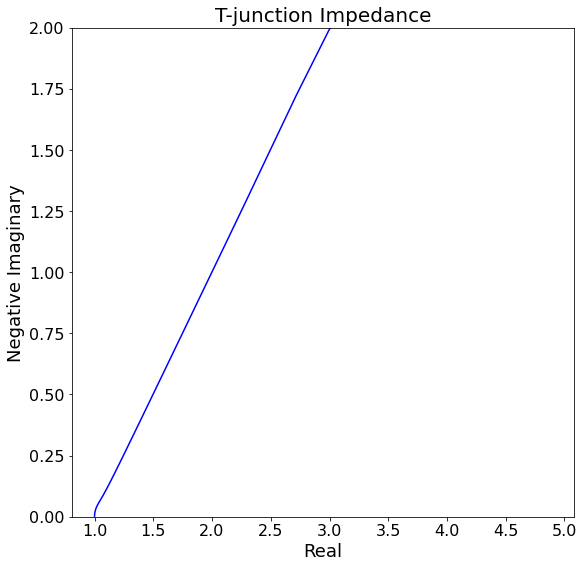

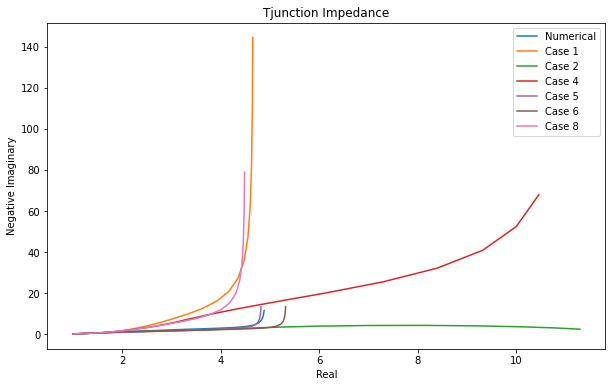

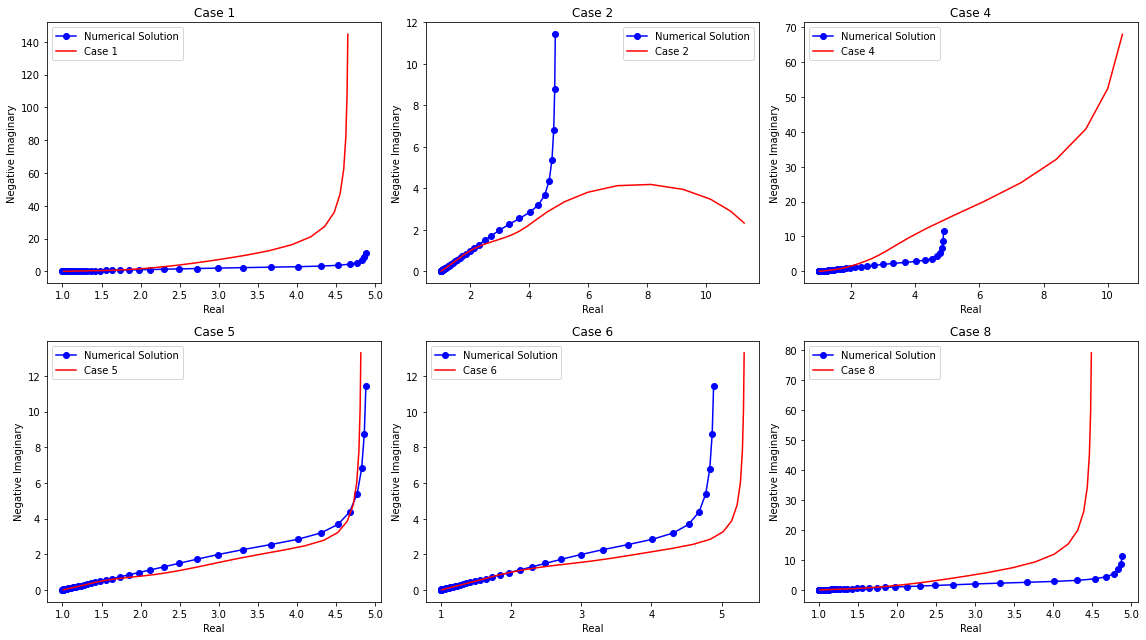

In [31]:
# Figure formatting
# Set figure size
plt.figure(figsize=(9, 9))
plt.plot(Z_num.real, -Z_num.imag, label = 'Numerical', color='blue')
# plt.plot(Z_ana.real, -Z_ana.imag, label = 'Analytical')

# Figure formatting
plt.title('T-junction Impedance', fontsize=20)
plt.xlabel('Real', fontsize=18)
plt.ylabel('Negative Imaginary', fontsize=18)
plt.ylim([0, 2])
plt.tick_params(axis='both', which='major', labelsize=16)
# plt.legend()

# Initialize a list of case arrays
case_arrays = [Z_case1, Z_case2, Z_case3, Z_case4, Z_case5, Z_case6, Z_case7, Z_case8]

# Case Analysis
# Compare every case to one another
for i in range(8):
    for j in range(i + 1, 8):
        if np.allclose(case_arrays[i], case_arrays[j], rtol=1e-5, atol=1e-5):
            print(f"Case {i + 1} and Case {j + 1} are nearly identical.")

# Calculate the absolute difference between the numerical solution and each case
errors = [np.abs(Z_num - Z_case) for Z_case in case_arrays]

# Find the index of the case with the smallest error
closest_case_index = np.argmin([np.linalg.norm(error) for error in errors])

# Print the index of the closest case
print(f"The case closest to the numerical solution is Case {closest_case_index + 1}")

# Plot relevant cases and numerical solution on the same plot
# Initialize a list of labels for the legend
filtered_labels = ['Numerical', 'Case 1', 'Case 2', 'Case 4', 'Case 5', 'Case 6', 'Case 8']

# Initialize a list of data arrays (exclude Case 3 and Case 7)
filtered_data_arrays = [Z_num, Z_case1, Z_case2, Z_case4, Z_case5, Z_case6, Z_case8]

# Set figure size
plt.figure(figsize=(10, 6))

# Plot real and negative imaginary parts for the filtered cases
for i in range(len(filtered_data_arrays)):
    plt.plot(filtered_data_arrays[i].real, -filtered_data_arrays[i].imag, label=filtered_labels[i])

# Figure formatting
plt.title('Tjunction Impedance')
plt.xlabel('Real')
plt.ylabel('Negative Imaginary')

# Add a legend
plt.legend()

# Plotting relevant cases and numerical solutions on different plots
# Create a list of labels without Case 3 and Case 7
filtered_labels = ['Numerical', 'Case 1', 'Case 2', 'Case 4', 'Case 5', 'Case 6', 'Case 8']

# Remaking case_array with only unique cases
filtered_case_arrays = [Z_case1, Z_case2, Z_case4, Z_case5, Z_case6, Z_case8]

# Create a 2x3 grid of subplots for the figures with a larger figure size
fig, axes = plt.subplots(2, 3, figsize=(16, 9))

for i, data in enumerate(filtered_case_arrays):
    # Calculate the subplot row and column
    row = i // 3
    col = i % 3

    # Determine the label based on the index
    label = filtered_labels[i]

    # Determine the case number based on the index
    case_number = [1, 2, 4, 5, 6, 8][i]

    # Plot real and negative imaginary parts of impedance on the corresponding subplot
    axes[row, col].plot(Z_num.real, -Z_num.imag, label='Numerical Solution', color='blue', marker='o')
    axes[row, col].plot(data.real, -data.imag, label=f'Case {case_number}', color='red')

    # Figure formatting for each subplot
    axes[row, col].set_title(f'Case {case_number}')
    axes[row, col].set_xlabel('Real')
    axes[row, col].set_ylabel('Negative Imaginary')

    # Add a legend for each subplot
    axes[row, col].legend()

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()